<Axes: xlabel='tmax', ylabel='tmax_tomorrow'>

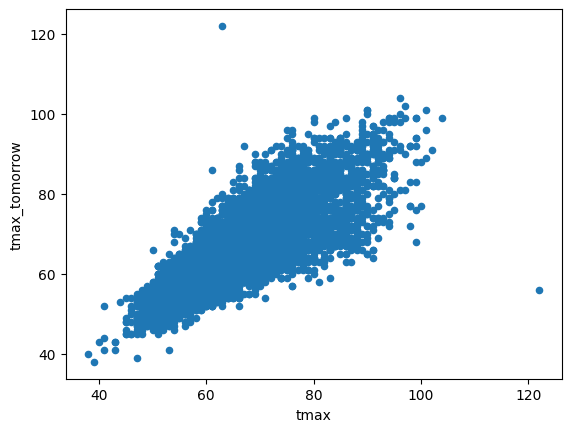

In [3]:
import pandas as pd

data = pd.read_csv("clean_weather.csv", index_col=0)
data = data.ffill()

data.plot.scatter('tmax', 'tmax_tomorrow')

In [4]:
data.corr()

,tmax,tmin,rain,tmax_tomorrow
tmax,1.000000,0.615604,-0.219941,0.818561
tmin,0.615604,1.000000,-0.019546,0.585572
rain,-0.219941,-0.019546,1.000000,-0.211799
tmax_tomorrow,0.818561,0.585572,-0.211799,1.000000


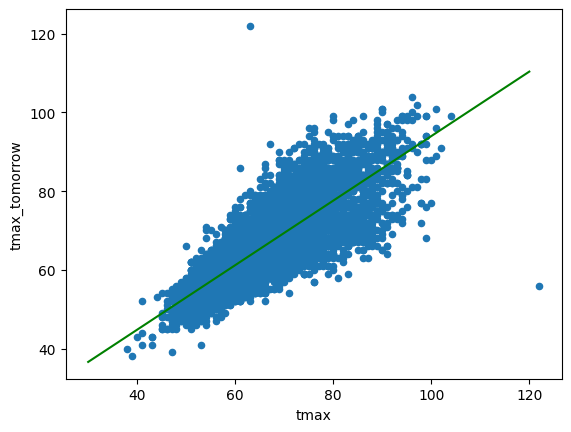

In [7]:
import matplotlib.pyplot as plt

data.plot.scatter('tmax', 'tmax_tomorrow')
prediction = lambda x, wl=.82, b=11.99: x * wl + b
plt.plot([30, 120], [prediction(30), prediction(120)], 'green')


In [6]:
import numpy as np

def mse(actual, predicted):
    return np.mean((actual - predicted) ** 2)

print(mse(data['tmax_tomorrow'], prediction(data['tmax'])))

189.2597331334664


#What do we do now?

In [8]:
tmax_bins = pd.cut(data['tmax'], 25)
tmax_bins

1970-01-01    (58.16, 61.52]
1970-01-02     (51.44, 54.8]
1970-01-03     (51.44, 54.8]
1970-01-04     (51.44, 54.8]
1970-01-05     (51.44, 54.8]
                   ...      
2022-11-22    (61.52, 64.88]
2022-11-23    (64.88, 68.24]
2022-11-24    (64.88, 68.24]
2022-11-25     (68.24, 71.6]
2022-11-26    (61.52, 64.88]
Name: tmax, Length: 13509, dtype: category
Categories (25, interval[float64, right]): [(37.916, 41.36] < (41.36, 44.72] < (44.72, 48.08] < (48.08, 51.44] ... (108.56, 111.92] < (111.92, 115.28] < (115.28, 118.64] < (118.64, 122.0]]

In [10]:
ratios = (data['tmax_tomorrow'] - 11.99) / data['tmax']
binned_ratio = ratios.groupby(tmax_bins).mean()
binned_ratio

C:\Users\lgibbons\AppData\Local\Temp\ipykernel_3116\2067207064.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_ratio = ratios.groupby(tmax_bins).mean()


tmax
(37.916, 41.36]     0.773904
(41.36, 44.72]      0.762256
(44.72, 48.08]      0.798484
(48.08, 51.44]      0.805470
(51.44, 54.8]       0.803930
(54.8, 58.16]       0.802731
(58.16, 61.52]      0.812934
(61.52, 64.88]      0.821545
(64.88, 68.24]      0.829101
(68.24, 71.6]       0.830022
(71.6, 74.96]       0.825879
(74.96, 78.32]      0.822207
(78.32, 81.68]      0.804168
(81.68, 85.04]      0.800264
(85.04, 88.4]       0.769633
(88.4, 91.76]       0.796350
(91.76, 95.12]      0.798793
(95.12, 98.48]      0.800002
(98.48, 101.84]     0.771846
(101.84, 105.2]     0.805621
(105.2, 108.56]          NaN
(108.56, 111.92]         NaN
(111.92, 115.28]         NaN
(115.28, 118.64]         NaN
(118.64, 122.0]     0.360738
dtype: float64

C:\Users\lgibbons\AppData\Local\Temp\ipykernel_3116\4180058181.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_tmax = data['tmax'].groupby(tmax_bins).mean()


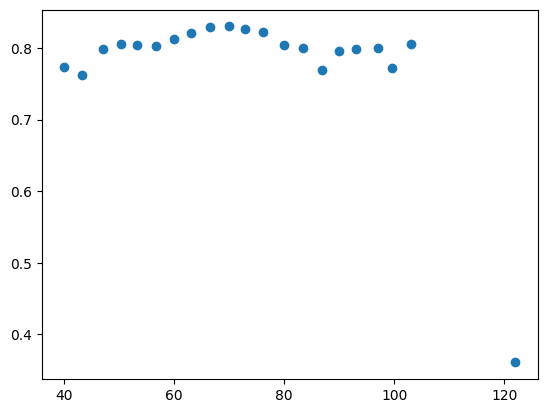

In [11]:
binned_tmax = data['tmax'].groupby(tmax_bins).mean()
plt.scatter(binned_tmax, binned_ratio)

# Key Things
Nonlinear transformation
multiple layers capture interactions
multiple hidden units which can have different transformations

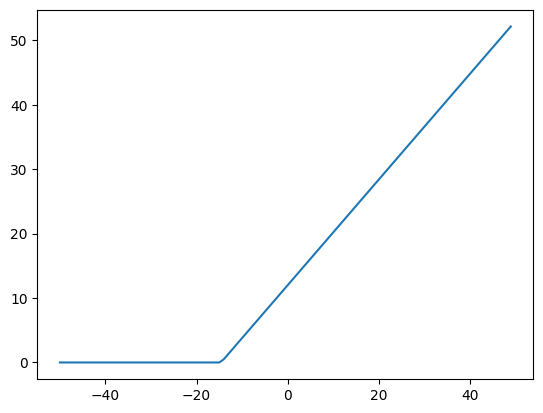

In [12]:
temps = np.arange(-50, 50)

plt.plot(temps, np.maximum(0, prediction(temps)))

$y = w_{2} relu(w_{1}x + b_{1}) + b_{2}$

This shows the multiple layers where we take the output of the first layer's relu and pass it as x into the second layer's function

(0.0, 40.0)

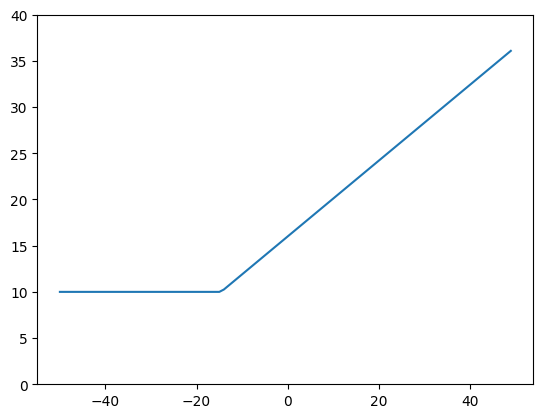

In [13]:
temps = np.arange(-50, 50)

layer1 = np.maximum(0, prediction(temps))
layer2 = prediction(layer1, .5, 10)

plt.plot(temps, layer2)

plt.ylim((0, 40))

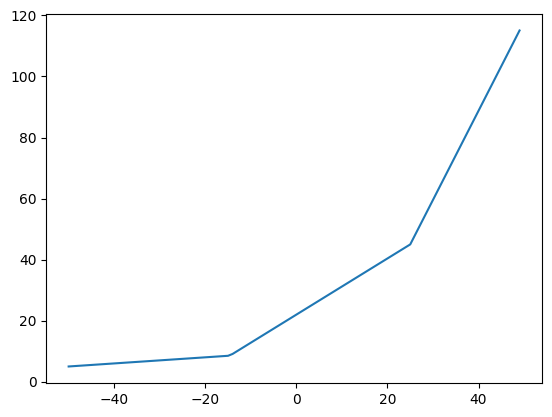

In [17]:
layer1_1 = np.maximum(0, prediction(temps))

layer_1_2 = np.maximum(0, prediction(temps, .1, 10))

layer_1_3 = np.maximum(0, prediction(temps, 2, -50))
plt.plot(temps, layer1_1 + layer_1_2 + layer_1_3)


#NOW MAKING IT

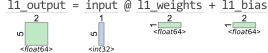

In [27]:
import tsensor

input = np.array([[80], [90], [100], [-20], [-10]])

l1_weights = np.array([[.82, .1]])
l1_bias = np.array([[11.99, 10]])

with tsensor.explain():
    l1_output = input @ l1_weights + l1_bias

In [29]:
l1_activated = np.maximum(l1_output, 0)

In [30]:
l1_activated

array([[77.59, 18.  ],
       [85.79, 19.  ],
       [93.99, 20.  ],
       [ 0.  ,  8.  ],
       [ 3.79,  9.  ]])

$layer_1 = relu(XW_1 + B_1)$

$\hat{y} = W_{2}relu(XW_{1} + B_{1}) + B_{2}$

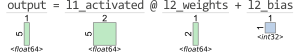

array([[47.395],
       [51.695],
       [55.995],
       [ 6.6  ],
       [ 8.695]])

In [31]:
l2_weights = np.array([
    [.5],
    [.2]
])
l2_bias = np.array([[5]])

with tsensor.explain():
    output = l1_activated @ l2_weights + l2_bias

output

In [32]:
tmax = np.array([[80], [90], [100], [-20], [-10]])
tmax_tomorrow = np.array([[83], [89], [95], [-22], [-9]])
tmax_tomorrow


array([[ 83],
       [ 89],
       [ 95],
       [-22],
       [ -9]])

In [33]:
def mse(actual, predicted):
    return (actual - predicted) ** 2

In [34]:
mse(tmax_tomorrow, output)

array([[1267.716025],
       [1391.663025],
       [1521.390025],
       [ 817.96    ],
       [ 313.113025]])

In [37]:
def mse_gradient(actual, predicted):
    return predicted - actual


In [38]:
mse_gradient(tmax_tomorrow, output)

array([[-35.605],
       [-37.305],
       [-39.005],
       [ 28.6  ],
       [ 17.695]])

#Backward Pass